Цель: предсказывать успешность сигналов, выдаваемых торговыми стратегиями.

Задача: фильтруем со всех тикеров строки с успешными сигналами и предсказываем вероятность успеха. Используем для этого классификатор. Строится общая модель для всех тикеров, но отдельная для каждого из сигналов. Из фичей удаляются все, которые могут имень значения цены или их не нормализованные производные (MA, MACD, AO, AC)

In [56]:
import pandas as pd
import numpy as np
import talib as ta
import pickle
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [168]:
predictprice, prctChange, probability = predict('ALRS', 'sig_breakVolatility', '2020-06-30')

print('Result: \n {0}'.format(probability))

Clf dataframe for signal sig_breakVolatility with direct "both" len: 466. Fill dataframe len was 1718
Model XGBClassifier for ALRS loaded from file ALRS-sig_breakVolatility-both-classifier.model
Model RandomForestRegressor for ALRS loaded from file ALRS-sig_breakVolatility-regressor.model
Predict ALRS on 2020-06-30. Current price is 64.49. Signal value for sig_breakVolatility is 1
Classifier model predict 1 with probability [0.1137777 0.8862223]
Regressor model predict 62.5357
Model predict price 62.5357 (-3.03%) for sig_breakVolatility with probability 0.8862223029136658
Result: 
 0.7089778423309326



Fit Classifier: 

Clf dataframe for signal sig_breakVolatility with direct "both" len: 1555. Fill dataframe len was 7211
ALRS dataset for fitting model:
Pos: 433   Neg: 910


AUC = 0.639	Accuracy = 0.632



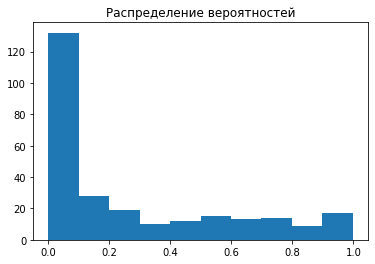

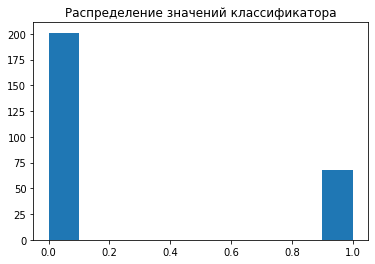

            features  importances
0  MA_fast_price_pos     0.057872
1   w1_WILLRdiv_long     0.056422
2      MACDdiv_short     0.050775
3        CCIdiv_long     0.050331
4    w1_prcntChng_15     0.048649
5             DivBar     0.044304
6            MACDchg     0.043189
7       CCIoverZones     0.042330
8     WILLRoverZones     0.040117
9     w1_prcntChng_5     0.038170


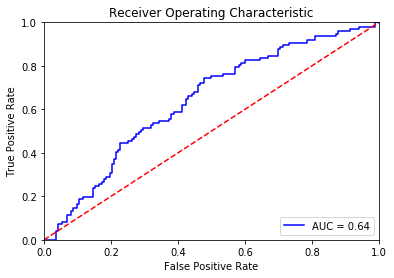



Confusion matrix:
   Pos  Neg
0  137   35
1   64   33
Model XGBClassifier for ALRS saved to file ALRS-sig_breakVolatility-both-classifier.model

Fit Regressor: 

train start: 2014-05-26 00:00:00
train end:   2019-04-09 00:00:00
test start:  2019-04-10 00:00:00
test end:    2020-07-03 00:00:00

Regressor score = 0.981



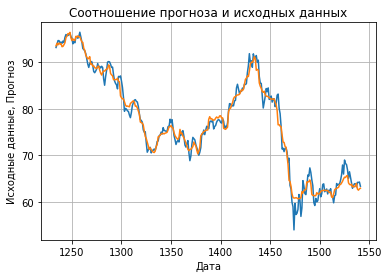

Model RandomForestRegressor for ALRS saved to file ALRS-sig_breakVolatility-regressor.model


'Model successfully fitted!'

In [127]:
fitpredictionmodel('ALRS', ['ALRS', 'GAZP', 'SBER', 'FIVE', 'NLMK'], 'sig_breakVolatility', shift=5, detailedresults=True)

In [161]:
# Additional functions

def get_sig_type(signal):
    if signal in ['sig_elder','sig_channel', 'sig_DivBar']:
        return 'direct'
    elif signal in ['sig_NR4ID', 'sig_breakVolatility']:
        return 'undirect'
    else:
        raise ValueError('Unexpected value of signal: "{0}"'.format(signal))
        
def check_signal(df_row, signal):
    if len(df_row) > 0:
        if df_row[signal][-1] != 0:
            return True
        else:
            return False
    else: 
        return False

# Возможные варианты целевых значений дельты:
# 1. Если сигнал имеет направленность "direct", то должны быть отдельная дельта для покупок и отдельная дельта для продажи.
# Для того, чтобы отфильтровать сигналы покупки и продажи, используется sig_value
# 2. Если сигнал не имеет направленности "undirect", то дельта должна определяться как разница между текущей и n периодов 
# назад, но плюс некий процент sig_perc
def create_delta_target_feature(df, shift, sig_type, sig_value=0, sig_perc=0):
    if sig_type == 'direct':       
        df['deltaPrice'] = df.close.shift(shift) - df.close
        df['deltaPrice'] = np.where((df['deltaPrice']/df['close']) > sig_perc, 1, 0)  ## 1 = цена возрастёт, 0 = цена упадёт        
    elif sig_type == 'undirect':       
        df['deltaPrice'] = abs(df.close.shift(shift) - df.close)
        df['deltaPrice'] = np.where((df['deltaPrice']/df['close']) > sig_perc, 1, 0)  ## 1 = цена возрастёт, 0 = цена упадёт  
    else:
        raise ValueError('Unexpected value of sig_type: "{0}"'.format(sig_type))
        
    return df['deltaPrice']

In [159]:
# Core functions

def fitpredictionmodel(ticker, tickers, signal, shift, detailedresults=False):
    #DataPath = config['PANDORA']['DataPath']
    DataPath = '../data/'
    #ModelsPath = config['PANDORA']['ModelsPath']
    ModelsPath = '../models/'
     
        
    # fit Classifier
    print('\nFit Classifier: \n')
    t_df_list = []
    for t in tickers:
        t_df_list.append(pd.read_csv(DataPath + t + '_processeddata.csv'))
    df_s = pd.concat(t_df_list)
    
    df_s['date_time'] = pd.to_datetime(df_s.date_time)
    df_s = df_s.set_index('date_time')
    
    if get_sig_type(signal) == 'undirect':
        df_clf = addfeatures_clf(df_s, signal)   
        x_train_cls, x_test_cls, y_train_cls, y_test_cls = preparedata_clf(df_clf, 
                                                                             tickers, 
                                                                             shift, 
                                                                             get_sig_type(signal))
        fitclassifier(ticker, tickers, signal, x_train_cls, x_test_cls, y_train_cls, y_test_cls, 
                      ModelsPath, detailedresults=detailedresults)
    elif get_sig_type(signal) == 'direct':
        for d in ['buy', 'sell']:
            df_clf = addfeatures_clf(df_s, signal, direct=d)   
            x_train_cls, x_test_cls, y_train_cls, y_test_cls = preparedata_clf(df_clf, 
                                                                                 tickers, 
                                                                                 shift, 
                                                                                 get_sig_type(signal))
            fitclassifier(ticker, tickers, signal, x_train_cls, x_test_cls, y_train_cls, y_test_cls, 
                          ModelsPath, detailedresults=detailedresults, direct=d)
    
    
    # fit Regressor
    print('\nFit Regressor: \n')
    df = pd.read_csv(DataPath + ticker + '_processeddata.csv')
    df['date_time'] = pd.to_datetime(df.date_time)
    df = df.set_index('date_time')
    df_reg = addfeatures_reg(df, signal)
    x_train_reg, x_test_reg, y_train_values_reg, y_test_values_reg = preparedata_reg(df_reg, ticker, shift)
    fitregressor(ticker, signal, x_train_reg, x_test_reg, y_train_values_reg, y_test_values_reg, 
                 ModelsPath, detailedresults=detailedresults)
    
    return 'Model successfully fitted!'

In [1]:
def predict(ticker, signal, predictdate, tickers=[]):
    #DataPath = config['PANDORA']['DataPath']
    DataPath = '../data/'
    #ModelsPath = config['PANDORA']['ModelsPath']
    ModelsPath = '../models/'
    
    df = pd.read_csv(DataPath + ticker + '_processeddata.csv')
    df['date_time'] = pd.to_datetime(df.date_time)
    df = df.set_index('date_time')
    
    if not check_signal(df[df.index==predictdate], signal):
        print('Nothing to predict for classifier because signal {0}, for date {1} is empty.'.format(signal, 
                                                                                                    predictdate))
        return 0, 0, 0
    
    # Classifier
    if get_sig_type(signal) == 'undirect':   
        d = 'both'
        df_clf = addfeatures_clf(df, signal)
    else:
        if df[df.index == predictdate][signal][-1] > 0:
            d = 'buy'
        else:
            d = 'sell'
        df_clf = addfeatures_clf(df, signal, direct=d)

    df_clf.drop(['close'], axis=1, inplace=True)

    filename = ticker + '-' + signal + '-' + d + '-classifier.model'
    with open(ModelsPath + filename, 'rb') as f:
        clf = pickle.load(f)
        print('Model XGBClassifier for {0} loaded from file {1}'.format(ticker, filename))

    predictdata = df_clf[df_clf.index==predictdate]
    clf_predict = clf.predict(predictdata)
    clf_proba = clf.predict_proba(predictdata)    
    
    # Regressor
    df_reg = addfeatures_reg(df, signal)
    filename = ticker + '-' + signal + '-regressor.model'
    with open(ModelsPath + filename, 'rb') as f:
        rgs = pickle.load(f)
        print('Model RandomForestRegressor for {0} loaded from file {1}'.format(ticker, filename))
    
    predictdata = df_reg[df_reg.index==predictdate]
    rgs_predict = rgs.predict(predictdata)
    
    print('Predict {0} on {1}. Current price is {2}. Signal value for {3} is {4}'.format(ticker, 
                                                                                         predictdate, 
                                                                                         predictdata.close.values[0],
                                                                                         signal,
                                                                                         predictdata['sig_target'].values[0]))
    print('Classifier model predict {0} with probability {1}'.format(clf_predict[0], clf_proba[0]))
    print('Regressor model predict {0}'.format(round(rgs_predict[0],4)))
    
    predictprice = round(rgs_predict[0],4)
    prctChange = round(((rgs_predict[0] - predictdata.close.values[0])/predictdata.close.values[0])*100, 2)
    probability = clf_proba[0][1] # всегда показываем только вероятность 1 (единицы), т.к. нас интересуют успешные сделки
    print('Model predict price {0} ({1}%) for {2} with probability {3}'.format(predictprice, prctChange, 
                                                                               signal, probability))   
    
    # Обрабатываем финальный результат
    if get_sig_type(signal) == 'undirect':
        if abs(prctChange) < 3:
            final_proba = probability * 0.6 # потом изменить на model acc
        else:
            final_proba = probability * 0.8 # потом изменить на model acc + некий коэф
    else:
        if df[signal][-1] > 0: # direct = 'buy'
            if prctChange > 0:
                final_proba = final_proba = probability * 0.8 # потом изменить на model acc + некий коэф
            else:
                final_proba = final_proba = probability * 0.6 # потом изменить на model acc + некий коэф
        else:                  # direct = 'sell'
            if prctChange < 0:
                final_proba = final_proba = probability * 0.8 # потом изменить на model acc + некий коэф
            else:
                final_proba = final_proba = probability * 0.6 # потом изменить на model acc + некий коэф
            
    
    return predictprice, prctChange, final_proba

In [80]:
# Add features

def addfeatures_clf(df, signal, direct='both'):
    df_feat = df.copy()
    df_feat['sig_target'] = df_feat[signal]
    if direct == 'both':
        df_feat = df_feat[df_feat.sig_target != 0]
    elif direct == 'buy':
        df_feat = df_feat[df_feat.sig_target > 0]
    elif direct == 'sell':
        df_feat = df_feat[df_feat.sig_target < 0]
    else:
        raise ValueError('Unexpected value of direct: "{0}"'.format(direct))
        
    print('Clf dataframe for signal {0} with direct "{3}" len: {1}. Fill dataframe len was {2}'.format(signal, 
                                                                                                     len(df_feat), 
                                                                                                     len(df),
                                                                                                     direct))
    df_feat.drop(['sig_elder','sig_channel', 'sig_DivBar', 'sig_NR4ID', 'sig_breakVolatility'], 
                 axis=1, inplace=True)
    
    # Т.к. мы объединили в себя несколько датафреймов разных символов, необходимо избавится от колонок, 
    # которые прямо или косвенно связаны с ценой, т.к. у модели могут получится разные порядки данных
    df_feat.drop(['open', 'low', 'high', 'vol', 'MA_fast', 'MA_slow', 'MACD', 'WILLR', 'CCI', 'upBB', 'midBB', 
             'lowBB', 'w1_open', 'w1_high', 'w1_low', 'w1_close', 'w1_vol', 'w1_MA_fast', 'w1_MA_slow', 'w1_MACD', 
             'w1_WILLR'], axis=1, inplace=True)
       
    df_feat.dropna(inplace=True)
    return df_feat

def addfeatures_reg(df, signal):
    df_feat = df.copy()
    df_feat['sig_target'] = df_feat[signal]
    df_feat.drop(['sig_elder','sig_channel', 'sig_DivBar', 'sig_NR4ID', 'sig_breakVolatility'], axis=1, inplace=True)
    
    df_feat.dropna(inplace=True)    
    return df_feat

In [117]:
# Prepare data for training

def preparedata_clf(df, tickers, shift, sig_type):           
    df['deltaPrice'] = df.close.shift(shift) - df.close
    df['deltaPrice'] = create_delta_target_feature(df, shift, sig_type, sig_value=0, sig_perc=0.05)
    
    df['ts'] = df.index.values
    df.reset_index(drop=True, inplace=True)
    
    df.dropna(inplace=True)
    
    splitCoef = 0.8 # 80 - тренировочный сет, 20 - тестовый сет
    
    ## считаем, сколько цен выше, и сколько ниже текущей (насколько сбалансирован дейтасет)
    countPos = len(df[df.deltaPrice == 1])
    countNeg = len(df[df.deltaPrice == 0])
    print(tickers[0] + ' dataset for fitting model:')
    print(f'Pos: {countPos}   Neg: {countNeg}\n')
    
    df_train, df_test = np.split(df, [int(splitCoef*len(df))])
    df_train.drop(['ts'], axis=1, inplace=True)
    df_test.drop(['ts'], axis=1, inplace=True)
    
    # подготавливаем сеты
    y_train = df_train.deltaPrice
    y_test  = df_test.deltaPrice
    
    df_train.drop(['deltaPrice', 'close'], axis=1, inplace=True)
    df_test.drop(['deltaPrice', 'close'], axis=1, inplace=True)
    x_train = df_train
    x_test  = df_test
    
    return x_train, x_test, y_train, y_test

def preparedata_reg(df, ticker, shift):        
    df['targetPrice'] = df.close.shift(shift)
    
    df['ts'] = df.index.values
    df.reset_index(drop=True, inplace=True)
    
    df.dropna(inplace=True)
    
    splitCoef = 0.8 # 80 - тренировочный сет, 20 - тестовый сет    
    df_train, df_test = np.split(df, [int(splitCoef*len(df))])
    print(f'train start: {df_train.ts.iloc[0]}')
    print(f'train end:   {df_train.ts.iloc[-1]}')
    print(f'test start:  {df_test.ts.iloc[0]}')
    print(f'test end:    {df_test.ts.iloc[-1]}')
    df_train.drop(['ts'], axis=1, inplace=True)
    df_test.drop(['ts'], axis=1, inplace=True)
    
    # подготавливаем сеты
    y_train_values = df_train.targetPrice
    y_test_values  = df_test.targetPrice
    
    df_train.drop(['targetPrice'], axis=1, inplace=True)
    df_test.drop(['targetPrice'], axis=1, inplace=True)
    x_train = df_train
    x_test  = df_test
    
    return x_train, x_test, y_train_values, y_test_values

In [123]:
# Fit classifier model

def fitclassifier(ticker, tickers, signal, x_train, x_test, y_train, y_test, 
                  modelspath, detailedresults=True, direct='both'):
    ## задаём веса для различных классов (балансировка данных)
    #classWeights = len(features[features.label == 0]) / len(features[features.label == 1])
    
    ## параметры классификатора
    xgbParameters = {
        'n_estimators': 500,              ## количество деревьев
        'learning_rate': 0.1,             ## скорость обучения
        'max_depth': 7,                   ## максимальная глубина деревьев
        'subsample': 1.0,                 ## Subsample ratio of the training instance.
        'reg_lambda': 1,                  ## коэффициент L2-регуляризации 
        #'scale_pos_weight': classWeights, ## балансировка данных
        'objective': 'binary:logistic',   ## тип задачи
        'random_state': 42,               ## зерно начального состояния
        'silent': False                   ## не выводить процесс обучения на экран
    }
    
    ## создаём и тренируем классификатор
    clf = xgb.XGBClassifier(**xgbParameters).fit(x_train, y_train)
    
    ## результаты 
    res = pd.concat([x_test, y_test], axis=1)
    res['pred'] = clf.predict(x_test)
    res['pred_proba'] = clf.predict_proba(x_test)[:, 1] ## вероятности
    
    # ошибки первого/второго рода и площать под ROC-кривой
    FPR, TPR, thresholds = roc_curve(res.deltaPrice, res.pred_proba)
    roc_auc = auc(FPR, TPR)
        
    ## точность
    acc = len(res[res.pred == res.deltaPrice]) / len(res)
    print(f"\nAUC = {roc_auc:.3f}\tAccuracy = {acc:.3f}\n")
    
    if detailedresults:
        ## выводим вероятности (уверенность классификтора) 
        plt.hist(res.pred_proba)
        plt.title('Распределение вероятностей')
        plt.show()

        ## выводим распределение значений
        plt.hist(res.pred)
        plt.title('Распределение значений классификатора')
        plt.show()

        ## значительность различных фич (feature importance)
        ftmprt = pd.DataFrame()
        ftmprt['features'] = x_train.columns
        ftmprt['importances'] = clf.feature_importances_
        ftmprt = ftmprt.sort_values('importances', ascending=False).reset_index(drop=True)
        print(ftmprt.head(10))

        # ROC-кривая
        plt.title('Receiver Operating Characteristic')
        plt.plot(FPR, TPR, 'b', label=f'AUC = {roc_auc:.2f}')
        plt.legend(loc='lower right')
        plt.plot([0, 1], [0, 1], 'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        ## матрица ошибок
        CM = confusion_matrix(res.deltaPrice, res.pred)
        CM_DF = pd.DataFrame(data=CM, columns = ['Pos', 'Neg'])
        print('\n\nConfusion matrix:')
        print(CM_DF)
    
    filename = ticker + '-' + signal + '-' + direct + '-classifier.model'
    with open(modelspath + filename, 'wb') as f:
        pickle.dump(clf, f)
        print('Model XGBClassifier for {0} saved to file {1}'.format(ticker, filename))

In [70]:
# Fit regressor model

def fitregressor(ticker, signal, x_train, x_test, y_train_values, y_test_values, modelspath, detailedresults=True):
    ## параметры для регрессора
    rfRegressorParams = {'n_estimators': 100, 'max_depth': 10, 'min_samples_split': 5, 'max_features' : 1.0}
    
    ## обучаем
    rgs = RandomForestRegressor(**rfRegressorParams).fit(x_train, y_train_values)
    
    ## применяем на тестовых данных
    y_pred_values = rgs.predict(x_test)
    
    ## score
    print(f"\nRegressor score = {rgs.score(x_test, y_test_values):.3f}\n")
    
    if detailedresults:
        ## визуализируем результат
        plt.title("Соотношение прогноза и исходных данных") # заголовок
        plt.xlabel("Дата")         # ось абсцисс
        plt.ylabel("Исходные данные, Прогноз")    # ось ординат
        plt.grid()              # включение отображение сетки
        plt.plot(x_test.index, y_test_values, x_test.index, y_pred_values)  # построение графика
        plt.show()
    
    filename = ticker + '-' + signal + '-regressor.model'
    with open(modelspath + filename, 'wb') as f:
        pickle.dump(rgs, f)
        print('Model RandomForestRegressor for {0} saved to file {1}'.format(ticker, filename))